In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def build_covariance_matrices(filename):
    II = hp.read_map(filename,field=0)
    IQ = hp.read_map(filename,field=1)
    IU = hp.read_map(filename,field=2)
    QQ = hp.read_map(filename,field=3)
    QU = hp.read_map(filename,field=4)
    UU = hp.read_map(filename,field=5)
    Npix = II.shape[0]
    Np_all = np.zeros((Npix, 3, 3))
    Np_all[:, 0, 0] = II   # II
    Np_all[:, 0, 1] = IQ   # IQ
    Np_all[:, 0, 2] = IU   # IU
    Np_all[:, 1, 0] = IQ   # IQ
    Np_all[:, 1, 1] = QQ   # QQ
    Np_all[:, 1, 2] = QU   # QU
    Np_all[:, 2, 0] = IU   # IU
    Np_all[:, 2, 1] = QU   # QU
    Np_all[:, 2, 2] = UU   # UU
    return Np_all

def hitmaps(filename):
    Np = build_covariance_matrices(filename)
    trace =  Np[:, 1, 1] + Np[:, 2, 2] + Np[:, 0, 0] 
    epsilon = 1e-20
    safe_trace = np.where(trace > epsilon, trace, np.inf)
    hitsmap = 1.0 / safe_trace
    return hitsmap

In [3]:
hitsmap_sat_30 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_sat_cov_SAT_f030.fits")
hitsmap_sat_40 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_sat_cov_SAT_f040.fits")

In [4]:
hitsmap_lat_wide_30 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_wide_cov_LAT_f030.fits")
hitsmap_lat_wide_40 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_wide_cov_LAT_f040.fits")

In [5]:
hitsmap_lat_delens1_30 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_delens_1_cov_LAT_f030.fits")
hitsmap_lat_delens1_40 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_delens_1_cov_LAT_f040.fits")
hitsmap_lat_delens2_30 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_delens_2_cov_LAT_f030.fits")
hitsmap_lat_delens2_40 = hitmaps("/global/cfs/cdirs/sobs/sims/full_season_depth_maps/full_season_lat_delens_2_cov_LAT_f040.fits")

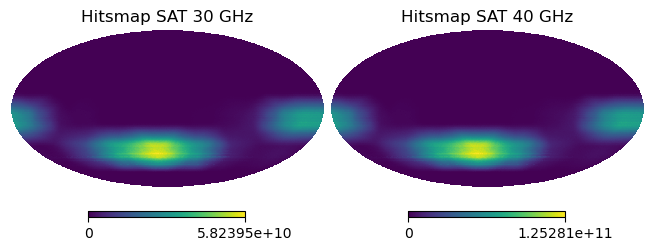

In [6]:
hp.mollview(hitsmap_sat_30, title="Hitsmap SAT 30 GHz", sub=(1,2,1))
hp.mollview(hitsmap_sat_40, title="Hitsmap SAT 40 GHz", sub=(1,2,2))

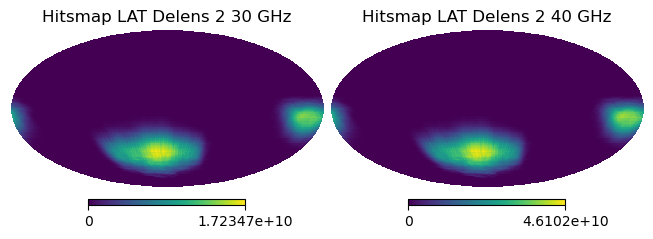

In [10]:
hp.mollview(hitsmap_lat_delens2_30, title="Hitsmap LAT Delens 2 30 GHz", sub=(2,2,1))
hp.mollview(hitsmap_lat_delens2_40, title="Hitsmap LAT Delens 2 40 GHz", sub=(2,2,2))

In [74]:
import numpy as np
import healpy as hp
from dataclasses import dataclass, field
from typing import Dict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


@dataclass
class HitsMapComparison:
    # mandatory maps
    sat_30: np.ndarray
    sat_40: np.ndarray
    lat_30: np.ndarray
    lat_40: np.ndarray
    nside: int

    # optional threshold to define “observed” pixels
    hit_thresh: float = 1e5

    # ------------------------------------------
    # masks are built lazily the first time needed
    # ------------------------------------------
    sat_30_mask: np.ndarray = field(init=False, repr=False)
    sat_40_mask: np.ndarray = field(init=False, repr=False)
    lat_30_mask: np.ndarray = field(init=False, repr=False)
    lat_40_mask: np.ndarray = field(init=False, repr=False)

    def __post_init__(self):
        self.sat_30_mask = self.sat_30 > self.hit_thresh
        self.sat_40_mask = self.sat_40 > self.hit_thresh
        self.lat_30_mask = self.lat_30 > self.hit_thresh
        self.lat_40_mask = self.lat_40 > self.hit_thresh

    # ---------- core utilities ----------
    def _fsky(self, mask: np.ndarray) -> float:
        return mask.mean()

    def _coverage_ratio(self, sat_mask, lat_mask):
        return (sat_mask & lat_mask).sum() / sat_mask.sum()

    def _jaccard(self, sat_mask, lat_mask):
        return (sat_mask & lat_mask).sum() / (sat_mask | lat_mask).sum()

    def _depth_stats(self, sat_hits, lat_hits, sat_mask, lat_mask,
                     high_frac: float = 0.90) -> Dict[str, float]:
        overlap = sat_mask & lat_mask
        r, _ = pearsonr(sat_hits[overlap], lat_hits[overlap])

        # high-hits region in SAT
        thresh = np.quantile(sat_hits[sat_mask], high_frac)
        top_sat = (sat_hits >= thresh) & sat_mask
        depth_ratio = np.median(lat_hits[top_sat] / sat_hits[top_sat])

        return dict(
            pearson_r=r,
            depth_ratio=depth_ratio,
            high_frac=high_frac
        )

    # ---------- public API ----------
    def summary(self, freq: str = "30", high_frac: float = 0.90) -> Dict[str, float]:
        if freq == "30":
            sat, lat = self.sat_30, self.lat_30
            sat_mask, lat_mask = self.sat_30_mask, self.lat_30_mask
        else:
            sat, lat = self.sat_40, self.lat_40
            sat_mask, lat_mask = self.sat_40_mask, self.lat_40_mask

        return {
            "f_sky_sat": self._fsky(sat_mask),
            "f_sky_lat": self._fsky(lat_mask),
            "coverage_ratio": self._coverage_ratio(sat_mask, lat_mask),
            "jaccard": self._jaccard(sat_mask, lat_mask),
            **self._depth_stats(sat, lat, sat_mask, lat_mask, high_frac),
        }

    # ---------- visualisations ----------
    def _show_map(self, m, title, vmin=None, vmax=None, cmap="viridis"):
        hp.mollview(m, title=title, unit="hits", min=vmin, max=vmax, cmap=cmap)
        hp.graticule()

    def plot_all(
        self,
        freq: str = "30",
        high_frac: float = 0.90,
        colors: tuple = (
            "none",          # 0 unseen
            "#1f77b4",       # 1 LAT only
            "#d62728",       # 2 SAT only
            "#9467bd",       # 3 overlap
            "#ffbf00",       # 4 SAT high-hits
        ),
        legend_loc: str = "lower left",
        bbox: tuple = (0.02, 0.02),
    ):
        """
        Draw a composite Mollweide map with an in-figure legend.

        Parameters
        ----------
        freq : {"30","40"}
            Channel to visualise.
        high_frac : float
            SAT pixels above this quantile are tagged "high-hits".
        colors : 5-tuple
            Hex / RGBA strings for [unseen, LAT only, SAT only, overlap,
            SAT high-hits].  Set the first to "none" for transparency.
        legend_loc : str
            Matplotlib legend location code (e.g. "lower left").
        bbox : (x, y)
            Anchor for the legend in axes coordinates.
        """
        import matplotlib.pyplot as plt
        from matplotlib.colors import ListedColormap
        import matplotlib.patches as mpatches

        # --- choose maps & masks --------------------------------------------
        if freq == "30":
            s_hits, l_hits = self.sat_30, self.lat_30
            s_mask,  l_mask = self.sat_30_mask, self.lat_30_mask
        else:
            s_hits, l_hits = self.sat_40, self.lat_40
            s_mask,  l_mask = self.sat_40_mask, self.lat_40_mask

        # --- logical masks ---------------------------------------------------
        overlap_mask   = s_mask & l_mask
        thresh         = np.quantile(s_hits[s_mask], high_frac)
        high_sat_mask  = (s_hits >= thresh) & s_mask

        # --- build category map ---------------------------------------------
        cat = np.zeros_like(s_mask, dtype=np.int8)
        cat[l_mask & ~s_mask]  = 1            # LAT only
        cat[s_mask & ~l_mask]  = 2            # SAT only
        cat[overlap_mask]      = 3            # overlap
        cat[high_sat_mask]     = 4            # high-hits override all

        # --- draw Mollweide --------------------------------------------------
        cmap = ListedColormap(colors, N=len(colors))
        hp.mollview(
            cat,
            title=f"Coverage map {freq} GHz",
            cmap=cmap,
            min=0,
            max=4,
            cbar=False,
            badcolor="lightgrey",
        )
        hp.graticule()

        # grab the current axis created by healpy
        ax = plt.gca()

        # --- legend ----------------------------------------------------------
        labels = [
            "unseen",
            "LAT only",
            "SAT only",
            "overlap",
            f"SAT top {int(np.ceil((1-high_frac)*100))} %",
        ]
        patches = [
            mpatches.Patch(color=c, label=l)
            for c, l in zip(colors, labels)
        ]
        ax.legend(
            handles=patches,
            loc=legend_loc,
            bbox_to_anchor=bbox,
            frameon=False,
            fontsize="small",
        )
        plt.show()

In [92]:
h = HitsMapComparison(
    sat_30=hitsmap_sat_30,
    sat_40=hitsmap_sat_40,
    lat_30=hitsmap_lat_delens2_30,
    lat_40=hitsmap_lat_delens2_40,
    nside=hp.npix2nside(hitsmap_sat_30.shape[0])
)

In [96]:
h.summary("40")

{'f_sky_sat': 0.5198713938395182,
 'f_sky_lat': 0.25478458404541016,
 'coverage_ratio': 0.45679275810915426,
 'jaccard': 0.44207227946006405,
 'pearson_r': 0.8657073812945056,
 'depth_ratio': 0.34552936442010146,
 'high_frac': 0.9}

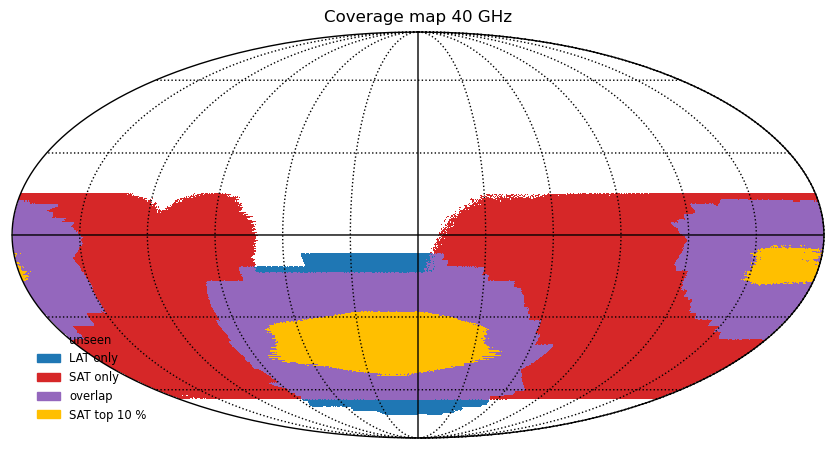

In [97]:
h.plot_all(freq="40")

In [73]:
int(np.ceil((1-.9)*100))

10